<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Sofia Jacinto</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20240598</td>
            </tr>
            <tr>
                <td style="padding: 8px;">José Cavaco</td>
                <td style="padding: 8px;"> 20240513</td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [1]:
#pip install gsgp_slim

In [2]:
# pip install slim_gsgp

In [3]:
#pip install -r requirements.txt

In [4]:
# Imports
import numpy as np
import pandas as pd

import os
import pickle
import datetime
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from itertools import product
import gc

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import wilcoxon, friedmanchisquare

from collections import Counter
from sklearn.metrics import mean_squared_error
import scikit_posthocs as sp

import warnings
warnings.filterwarnings('ignore')

In [5]:
from slim.main_gp import gp  # import the slim library
from slim.datasets.data_loader import load_ppb  # import the loader for the dataset PPB
from slim.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim.utils.utils import train_test_split  # import the train-test split function

C:\Users\catar\AppData\Local\Temp\ipykernel_37820\1154811637.py:1: DeprecationWarning: The `gsgp_slim` package is deprecated. Please use the `slim_gsgp` package instead: https://pypi.org/project/slim_gsgp/
  from slim.main_gp import gp  # import the slim library


In [6]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [7]:
train_color = 'blue'
test_color = 'orange'

In [8]:
#! ls

#### Helpfull Functions

In [9]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [10]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

c:\Users\catar\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\catar\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [11]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [12]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [14]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [15]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [16]:
df.set_index('wing_tag', inplace = True)

In [17]:
df.duplicated().sum()

0

#### Data Types

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [19]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [20]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [21]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [22]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

c:\Users\catar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\catar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\catar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



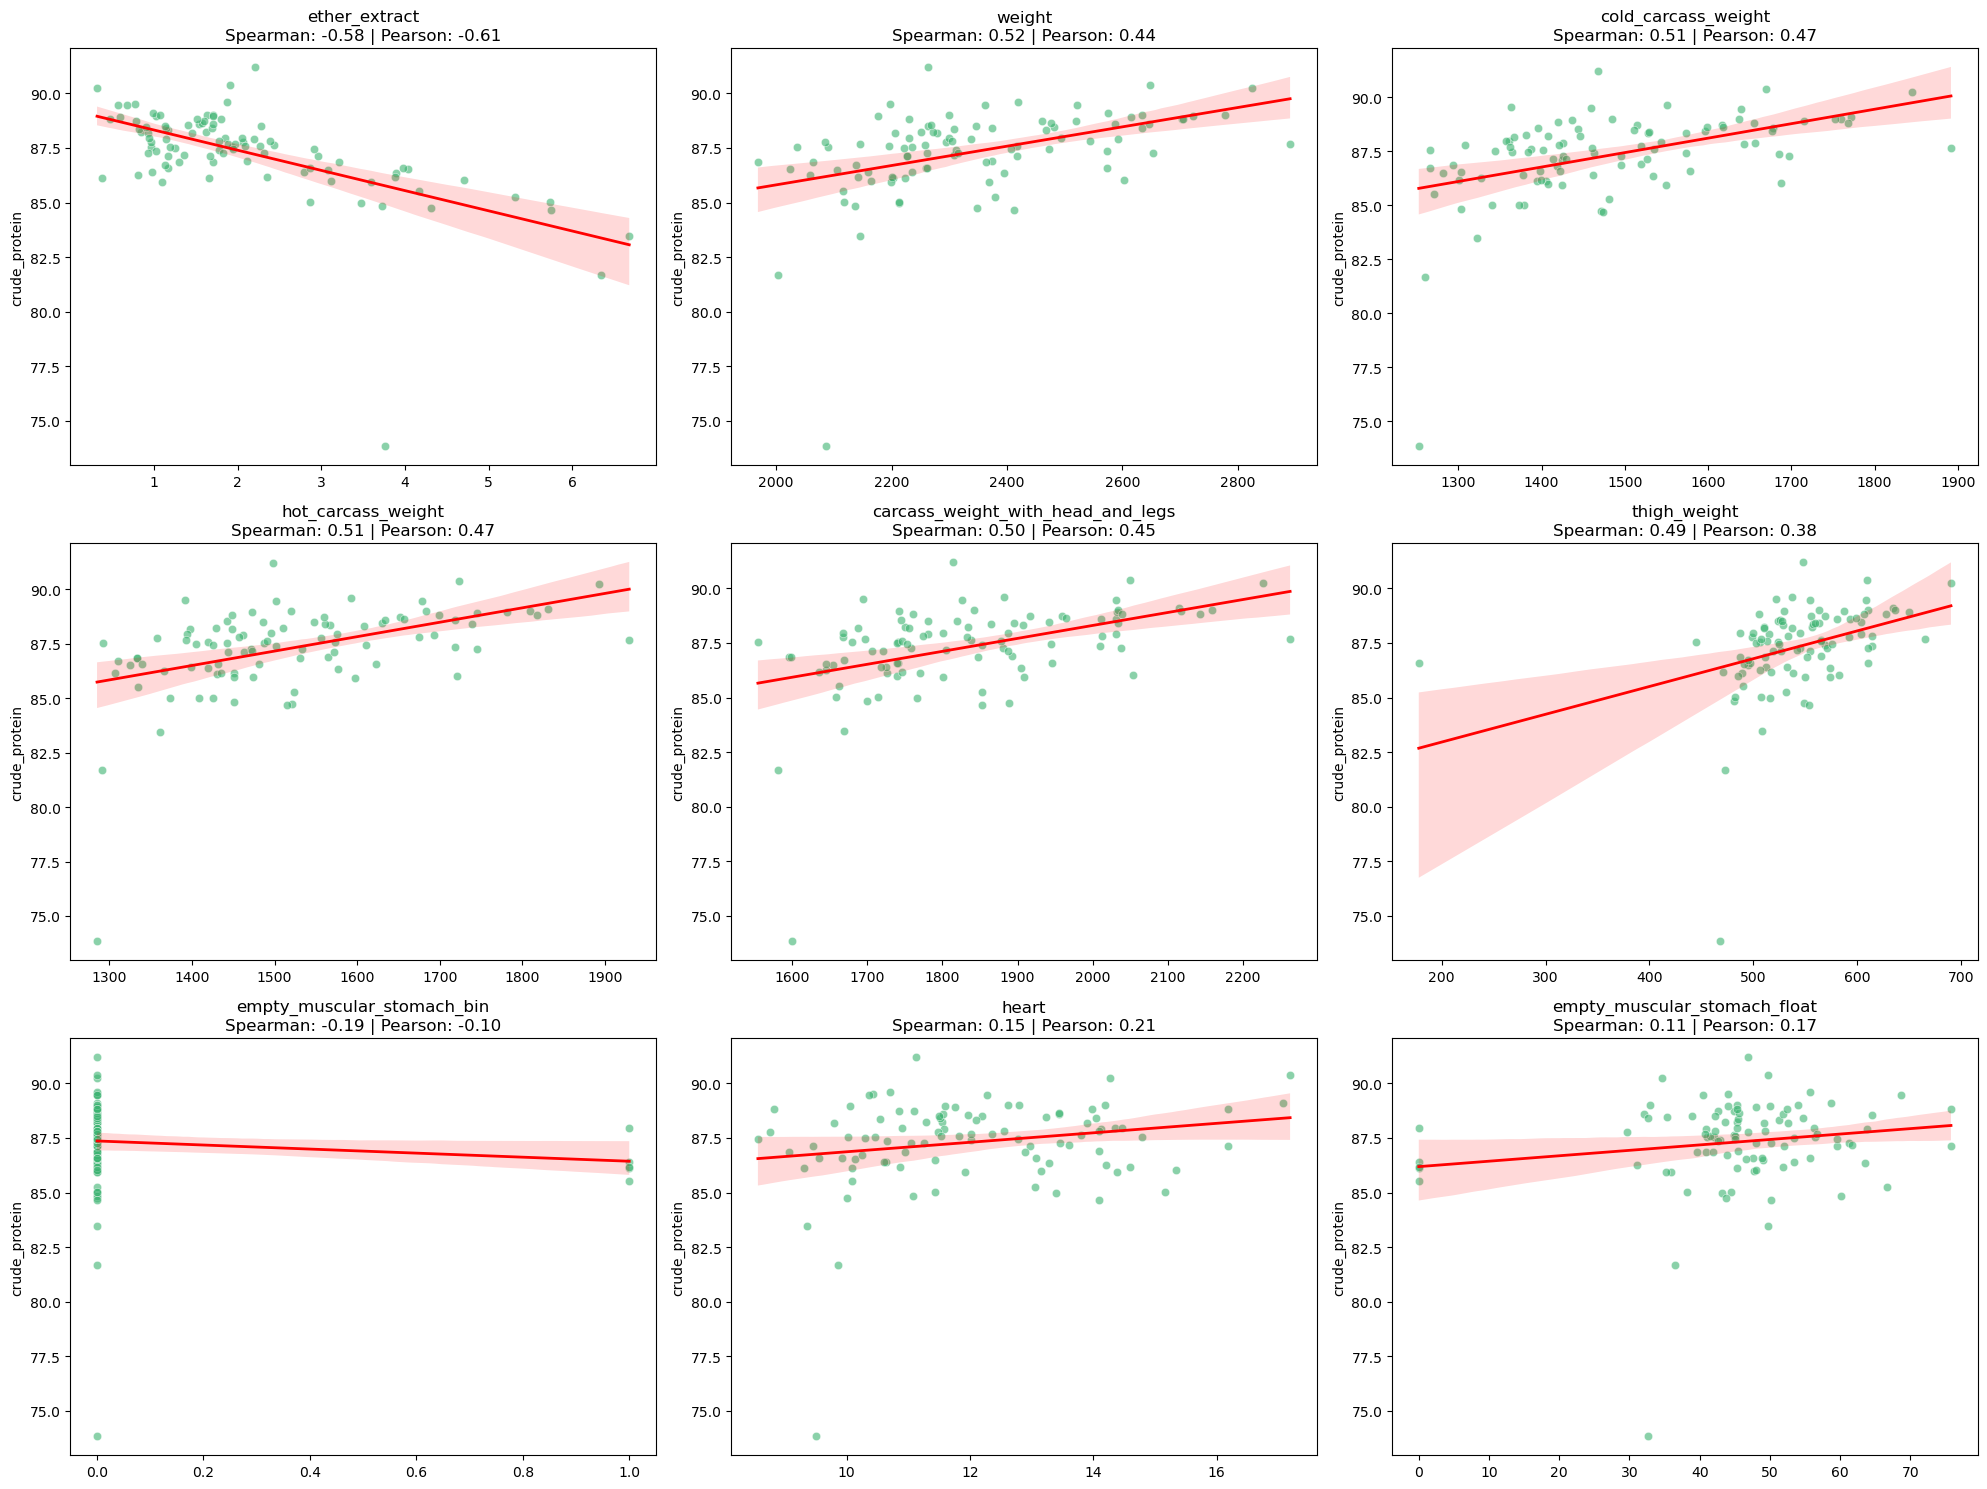

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [23]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

When  picking features for modeling, it's crucial to give a special focus on those that have the strongest correlation with the target variable, since they tend to boost predictive performance the most.

In this scenario, features like ether_extract, weight, cold_carcass_weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and thigh_weight stand out with the highest correlation to the target, making them key candidates for inclusion. 

But just because a feature has a high correlation doesn’t mean thy are useless, features that might seem less significant on their own—like heart, liver, or breast_weight—can still bring value when paired with others, especially in non-linear models or when considering interaction effects. So, while the strongest features lay a solid groundwork, it’s wise not to overlook the weaker ones too quickly without doing some additional testing in the modeling process.

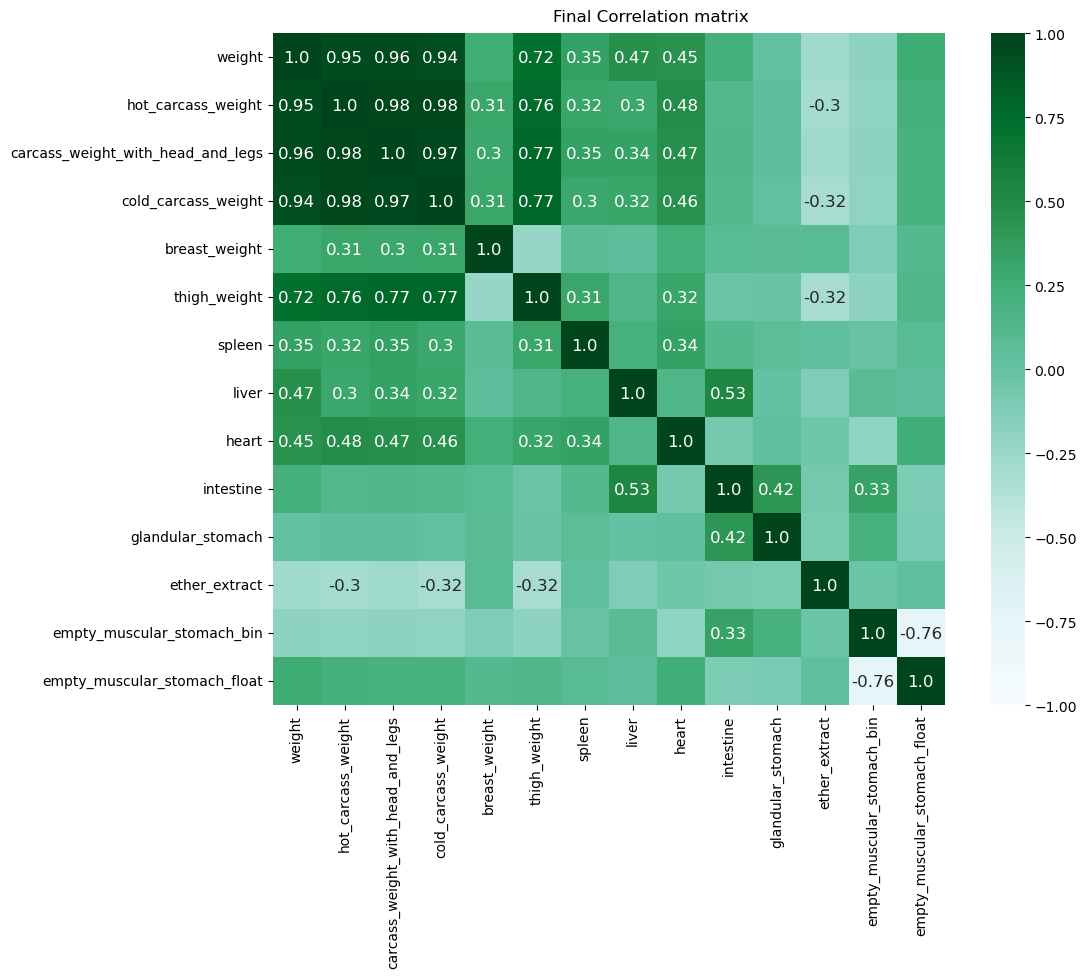

In [24]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

The correlation matrix reveals some strong linear relationships among various variables, which points to possible redundancy in the dataset:

- For example, weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and cold_carcass_weight are all highly correlated with each other, with values ranging from 0.94 to 0.98, very high. This indicates that including all four in a model or analysis could lead to multicollinearity issues.

- So, to simplify, we might want to keep just one representative variable—like hot_carcass_weight—and leave the others out.. Similarly, thigh_weight has a strong correlation with the carcass weights (up to 0.77), suggesting it could also be somewhat redundant if we already have carcass weight in the mix.



We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [25]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [26]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

`IMPORTANT:`the project description spcifically says "predict the crude protein weight using the remaining features in the dataset, excluding the animal ID." so we corrected the `empty_muscular_stomach` but we will not perform feature selection at this stage, basically we ll have this initial approach were we will test the models with all the features. If futher instructions state otherwise we will follow the analysis above.

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim)
- [5. Neural Network (NN)](#nn)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [27]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [28]:
k_outer = 5
k_inner = 3
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=seed)

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



- Dataset size: 96 samples -> GP can overfit easily on small data if trees get too big or the population too complex

In [29]:
# ===================== Nested CV Generator =====================
def nested_cv_generator(X, y, k_outer=10, k_inner=3, random_state=None):
    """ https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/"""
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
    for outer_train_idx, outer_test_idx in outer_cv.split(X):
        X_outer_train = X.iloc[outer_train_idx].reset_index(drop=True)
        y_outer_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)
        inner_splits = list(inner_cv.split(X_outer_train))

        yield {
            'X_outer_train': X_outer_train,
            'y_outer_train': y_outer_train,
            'X_test': X_test,
            'y_test': y_test,
            'inner_splits': inner_splits,
        }

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

In [30]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

> since this delivery i about GP we will keep this massive code in here to be easier to evaluate but in the final project we will do it in python file and import the function (if its ok of course) to make the notebook cleaner

In [31]:
def nested_cv_gp_slim_gsgp(
    X, y, param_grid, k_outer=5, k_inner=3, dataset_name="Chicken", gp_class=None, seed=42, alpha_sig=0.05
):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    outer_scores = []
    best_grid_models = []
    validation_results = []  # This will store detailed results for analysis
    detailed_results = []  # New: will store all fold results for all configs

    os.makedirs("./log/GP/", exist_ok=True)

    keys, values = zip(*param_grid.items())
    param_combos = [dict(zip(keys, v)) for v in product(*values)]

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer=k_outer, k_inner=k_inner, random_state=seed)):
        print(f"\n========== OUTER FOLD {fold_idx+1}/{k_outer} ==========")

        best_config = None
        best_val_score = float('inf')
        all_inner_fold_scores = []  # will be list of [k_inner] RMSEs per config

        # ============ Grid Search on Inner CV ============ #
        for config_id, flat_config in enumerate(param_combos):
            gp_config = {
                'initializer': flat_config['initializer'],
                'sspace': {
                    'p_constants': flat_config['sspace.p_constants'],
                    'max_init_depth': flat_config['sspace.max_init_depth'],
                    'max_depth': flat_config['sspace.max_depth'],
                    'tree_constants': flat_config['sspace.tree_constants'],
                },
                'pop_size': flat_config['pop_size'],
                'xo_prob': flat_config['xo_prob'],
                'generations': flat_config['generations'],
                'seed': seed
            }

            inner_fold_rmses = []

            for inner_fold_idx, (inner_train_idx, inner_val_idx) in enumerate(fold_data['inner_splits']):
                X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
                y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
                X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
                y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

                # Scaling
                x_scaler = RobustScaler()
                y_scaler = RobustScaler()
                X_train_scaled = x_scaler.fit_transform(X_train)
                X_val_scaled = x_scaler.transform(X_val)
                y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

                # Tensors
                X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

                # Model training
                model = gp_class(
                    X_train=X_train_tensor, y_train=y_train_tensor,
                    X_test=X_val_tensor, y_test=y_val_tensor,
                    dataset_name=dataset_name,
                    fitness_function='rmse',
                    minimization=True,
                    initializer=gp_config['initializer'],
                    tree_constants=gp_config['sspace']['tree_constants'],
                    tree_functions=['add', 'subtract', 'multiply', 'divide'],
                    prob_const=gp_config['sspace']['p_constants'],
                    init_depth=gp_config['sspace']['max_init_depth'],
                    max_depth=gp_config['sspace']['max_depth'],
                    pop_size=gp_config['pop_size'],
                    p_xo=gp_config['xo_prob'],
                    elitism=True,
                    n_elites=1,
                    tournament_size=2,
                    n_iter=gp_config['generations'],
                    test_elite=True,
                    log_level=0,
                    verbose=0,
                    n_jobs=1,
                    seed=gp_config['seed']
                )

                # Evaluation
                with torch.no_grad():
                    y_pred_scaled = model.predict(X_val_tensor).numpy()
                    y_true_scaled = y_val_tensor.numpy()

                    # Inverse transform to original scale
                    y_pred = safe_inverse_transform(y_scaler, y_pred_scaled)
                    y_true = safe_inverse_transform(y_scaler, y_true_scaled)

                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    inner_fold_rmses.append(rmse)
                    
                    # Store detailed results for this fold and config
                    detailed_results.append({
                        'outer_fold': fold_idx + 1,
                        'inner_fold': inner_fold_idx + 1,
                        'config_id': config_id,
                        'config': str(flat_config),  # String representation
                        'rmse': rmse
                    })

            avg_val_rmse = np.mean(inner_fold_rmses)
            all_inner_fold_scores.append(inner_fold_rmses)

            print(f"  Config {config_id+1}/{len(param_combos)} | Inner Mean RMSE: {avg_val_rmse:.4f}")

            if avg_val_rmse < best_val_score:
                best_val_score = avg_val_rmse
                best_config = gp_config

        print(f"\n✅ Best config for outer fold {fold_idx+1}:")
        print(best_config)
        print(f"Best inner RMSE: {best_val_score:.4f}")
        best_grid_models.append(best_config)

        # Convert to DataFrame for statistical tests
        df_inner_scores = pd.DataFrame(all_inner_fold_scores).T  # shape: (k_inner, n_configs)
        validation_results.append(df_inner_scores)

        # ============ Statistical Tests ============ #
        print("\nStatistical test on inner fold scores:")
        stat, p = friedmanchisquare(*[df_inner_scores[col] for col in df_inner_scores.columns])
        print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")
        if p < alpha_sig:
            posthoc_result = sp.posthoc_nemenyi_friedman(df_inner_scores.to_numpy())
            significant_columns = posthoc_result.columns[posthoc_result.lt(0.05).any(axis=0)]
            filtered_result = posthoc_result[posthoc_result < alpha_sig]
            filtered_result = filtered_result.dropna(how='all').dropna(axis=1, how='all').fillna('-')
            print("P-values of significant differences:")
            print(filtered_result)
        else:
            print("No significant differences found between configs.")

        # ============ Boxplot ============ #
        # Convert detailed results to DataFrame for this outer fold
        df_fold_results = pd.DataFrame([r for r in detailed_results if r['outer_fold'] == fold_idx + 1])
        
        # Create labels for configurations
        config_labels = {
            i: f"Config {i+1}<br>" + "<br>".join(
                [f"{k}: {v}"[:30] for k, v in param_combos[i].items()]  # Corta cada item em 30 chars
            )
            for i in range(len(param_combos))
        }
        df_fold_results['config_label'] = df_fold_results['config_id'].map(config_labels)

        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_fold_results['config_label'],
            y=df_fold_results['rmse'],
            fillcolor='rgba(108, 140, 200, 0.3)',
            line=dict(color='rgba(108, 140, 200, 1)'),
            boxpoints='all',
            jitter=0,
            pointpos=0,
            marker=dict(color='rgba(108, 140, 200, 1)')
        ))
        fig.update_layout(
            title=f'Inner CV RMSEs - Outer Fold {fold_idx+1}',
            yaxis_title='Validation RMSE',
            width=200 * len(param_combos),
            height=400,
            plot_bgcolor='#f1f1f1',
            xaxis_tickangle=-90,
            margin=dict(l=50, r=50, t=50, b=20),
            showlegend=False
        )
        fig.show()


        # ============ Retrain on Outer Train, Evaluate on Outer Test ============ #
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_outer_train_scaled = x_scaler.fit_transform(fold_data['X_outer_train'])
        X_test_scaled = x_scaler.transform(fold_data['X_test'])
        y_outer_train_scaled = y_scaler.fit_transform(fold_data['y_outer_train'].values.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(fold_data['y_test'].values.reshape(-1, 1)).flatten()

        X_outer_train_tensor = torch.tensor(X_outer_train_scaled, dtype=torch.float32)
        y_outer_train_tensor = torch.tensor(y_outer_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_outer_train_tensor, y_train=y_outer_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name=dataset_name,
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['sspace']['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['sspace']['p_constants'],
            init_depth=best_config['sspace']['max_init_depth'],
            max_depth=best_config['sspace']['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=0,
            verbose=0,
            n_jobs=1,
            seed=best_config['seed']
        )

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            test_rmse = np.sqrt(mean_squared_error(fold_data['y_test'], y_pred_rescaled))

        print(f"\n[Outer Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)
        gc.collect()

    print(f"\n================ Final Results ================\nMean RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    df_all_results = pd.DataFrame(detailed_results)
    return np.array(outer_scores), best_grid_models, df_all_results, validation_results

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |


In [32]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.5], 
    'sspace.max_init_depth': [3, 5],
    'sspace.max_depth': [10],
    'sspace.tree_constants': [TREE_CONSTANTS],
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [30],
}

# Seeds to test
seeds = [42, 123, 456]  # You can change these to any seeds you prefer

# Store results from all seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Run the experiment
    scores, best_models, df_results, val_results = nested_cv_gp_slim_gsgp(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=gp,
        k_outer=5, k_inner=3,
        seed=seed
    )
    
    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.8603
  Config 2/32 | Inner Mean RMSE: 1.9002
  Config 3/32 | Inner Mean RMSE: 1.6543
  Config 4/32 | Inner Mean RMSE: 1.9240
  Config 5/32 | Inner Mean RMSE: 1.9247
  Config 6/32 | Inner Mean RMSE: 127.2613
  Config 7/32 | Inner Mean RMSE: 1.7336
  Config 8/32 | Inner Mean RMSE: 1.9602
  Config 9/32 | Inner Mean RMSE: 1.8833
  Config 10/32 | Inner Mean RMSE: 1.9641
  Config 11/32 | Inner Mean RMSE: 1.6543
  Config 12/32 | Inner Mean RMSE: 1.8572
  Config 13/32 | Inner Mean RMSE: 2.0271
  Config 14/32 | Inner Mean RMSE: 1.7692
  Config 15/32 | Inner Mean RMSE: 1.7762
  Config 16/32 | Inner Mean RMSE: 1.8365
  Config 17/32 | Inner Mean RMSE: 2.0864
  Config 18/32 | Inner Mean RMSE: 1.9380
  Config 19/32 | Inner Mean RMSE: 2.7775
  Config 20/32 | Inner Mean RMSE: 2.0365
  Config 21/32 | Inner Mean RMSE: 1.7921
  Config 22/32 | Inner Mean RMSE: 2.0495
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 1] Test RMSE: 1.7715

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.4449
  Config 2/32 | Inner Mean RMSE: 2.1495
  Config 3/32 | Inner Mean RMSE: 2.7868
  Config 4/32 | Inner Mean RMSE: 4.5620
  Config 5/32 | Inner Mean RMSE: 2.8327
  Config 6/32 | Inner Mean RMSE: 2.8336
  Config 7/32 | Inner Mean RMSE: 1.6938
  Config 8/32 | Inner Mean RMSE: 2.7019
  Config 9/32 | Inner Mean RMSE: 1.9642
  Config 10/32 | Inner Mean RMSE: 2.0309
  Config 11/32 | Inner Mean RMSE: 1.5639
  Config 12/32 | Inner Mean RMSE: 1.8370
  Config 13/32 | Inner Mean RMSE: 1.9095
  Config 14/32 | Inner Mean RMSE: 4.6308
  Config 15/32 | Inner Mean RMSE: 1.9111
  Config 16/32 | Inner Mean RMSE: 85.2851
  Config 17/32 | Inner Mean RMSE: 5.1416
  Config 18/32 | Inner Mean RMSE: 2.1538
  Config 19/32 | Inner Mean RMSE: 2.9573
  Config 20/32 | Inner Mean RMSE: 4.6060
  Config 21/32 | Inner Mean RMSE: 6.9309
  Config 22/32 | Inner Mean RMSE: 2.6570
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 2] Test RMSE: 1.3470

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.5275
  Config 2/32 | Inner Mean RMSE: 1.4602
  Config 3/32 | Inner Mean RMSE: 1.4165
  Config 4/32 | Inner Mean RMSE: 1.2539
  Config 5/32 | Inner Mean RMSE: 4.0523
  Config 6/32 | Inner Mean RMSE: 1.4006
  Config 7/32 | Inner Mean RMSE: 1.6012
  Config 8/32 | Inner Mean RMSE: 1.3920
  Config 9/32 | Inner Mean RMSE: 1.5057
  Config 10/32 | Inner Mean RMSE: 1.3665
  Config 11/32 | Inner Mean RMSE: 1.3426
  Config 12/32 | Inner Mean RMSE: 1.3878
  Config 13/32 | Inner Mean RMSE: 1.4944
  Config 14/32 | Inner Mean RMSE: 1.4029
  Config 15/32 | Inner Mean RMSE: 1.1046
  Config 16/32 | Inner Mean RMSE: 1.3871
  Config 17/32 | Inner Mean RMSE: 1.5673
  Config 18/32 | Inner Mean RMSE: 1.3182
  Config 19/32 | Inner Mean RMSE: 1.1345
  Config 20/32 | Inner Mean RMSE: 1.7336
  Config 21/32 | Inner Mean RMSE: 1.4711
  Config 22/32 | Inner Mean RMSE: 1.1773
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 3] Test RMSE: 2.8135

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.9025
  Config 2/32 | Inner Mean RMSE: 1.8661
  Config 3/32 | Inner Mean RMSE: 2.7425
  Config 4/32 | Inner Mean RMSE: 2.6416
  Config 5/32 | Inner Mean RMSE: 1.8011
  Config 6/32 | Inner Mean RMSE: 25.3312
  Config 7/32 | Inner Mean RMSE: 4.1732
  Config 8/32 | Inner Mean RMSE: 1.8217
  Config 9/32 | Inner Mean RMSE: 1.7806
  Config 10/32 | Inner Mean RMSE: 2.1789
  Config 11/32 | Inner Mean RMSE: 1.7512
  Config 12/32 | Inner Mean RMSE: 1.8843
  Config 13/32 | Inner Mean RMSE: 2.0607
  Config 14/32 | Inner Mean RMSE: 2.0007
  Config 15/32 | Inner Mean RMSE: 3.5108
  Config 16/32 | Inner Mean RMSE: 2.0558
  Config 17/32 | Inner Mean RMSE: 1.6213
  Config 18/32 | Inner Mean RMSE: 1.8660
  Config 19/32 | Inner Mean RMSE: 3.6887
  Config 20/32 | Inner Mean RMSE: 2.1806
  Config 21/32 | Inner Mean RMSE: 1.8681
  Config 22/32 | Inner Mean RMSE: 2.1078
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 4] Test RMSE: 1.4551

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.7003
  Config 2/32 | Inner Mean RMSE: 2.3417
  Config 3/32 | Inner Mean RMSE: 1.9921
  Config 4/32 | Inner Mean RMSE: 2.1500
  Config 5/32 | Inner Mean RMSE: 4.5764
  Config 6/32 | Inner Mean RMSE: 2.4382
  Config 7/32 | Inner Mean RMSE: 1.5739
  Config 8/32 | Inner Mean RMSE: 1.5958
  Config 9/32 | Inner Mean RMSE: 1.9583
  Config 10/32 | Inner Mean RMSE: 2.0107
  Config 11/32 | Inner Mean RMSE: 1.8527
  Config 12/32 | Inner Mean RMSE: 1.8939
  Config 13/32 | Inner Mean RMSE: 2.0256
  Config 14/32 | Inner Mean RMSE: 2.0915
  Config 15/32 | Inner Mean RMSE: 2.8387
  Config 16/32 | Inner Mean RMSE: 1.7924
  Config 17/32 | Inner Mean RMSE: 1.7089
  Config 18/32 | Inner Mean RMSE: 1.9991
  Config 19/32 | Inner Mean RMSE: 1.8493
  Config 20/32 | Inner Mean RMSE: 2.3363
  Config 21/32 | Inner Mean RMSE: 3.0194
  Config 22/32 | Inner Mean RMSE: 1.9167
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 5] Test RMSE: 1.2561

================ Final Results ================
Mean RMSE: 1.7287 ± 0.5696

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.5922
  Config 2/32 | Inner Mean RMSE: 1.6724
  Config 3/32 | Inner Mean RMSE: 1.2057
  Config 4/32 | Inner Mean RMSE: 1.7295
  Config 5/32 | Inner Mean RMSE: 1.1192
  Config 6/32 | Inner Mean RMSE: 1.2624
  Config 7/32 | Inner Mean RMSE: 1.2585
  Config 8/32 | Inner Mean RMSE: 1.3451
  Config 9/32 | Inner Mean RMSE: 1.1833
  Config 10/32 | Inner Mean RMSE: 1.1839
  Config 11/32 | Inner Mean RMSE: 1.3651
  Config 12/32 | Inner Mean RMSE: 1.2379
  Config 13/32 | Inner Mean RMSE: 1.1826
  Config 14/32 | Inner Mean RMSE: 1.2924
  Config 15/32 | Inner Mean RMSE: 1.1597
  Config 16/32 | Inner Mean RMSE: 1.1869
  Config 17/32 | Inner Mean RMSE: 1.2446
  Config 18/32 | Inner Mean RMSE: 1.2760
  Config 19/32 | Inner Mean RMSE: 1.1427
  Config 20/32 | Inner Mean RMSE: 1.1810
  Config


[Outer Fold 1] Test RMSE: 3.1687

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.2790
  Config 2/32 | Inner Mean RMSE: 2.4191
  Config 3/32 | Inner Mean RMSE: 1.7263
  Config 4/32 | Inner Mean RMSE: 1.9717
  Config 5/32 | Inner Mean RMSE: 1.7021
  Config 6/32 | Inner Mean RMSE: 1.8066
  Config 7/32 | Inner Mean RMSE: 1.6643
  Config 8/32 | Inner Mean RMSE: 1.8879
  Config 9/32 | Inner Mean RMSE: 1.6265
  Config 10/32 | Inner Mean RMSE: 1.8392
  Config 11/32 | Inner Mean RMSE: 1.9441
  Config 12/32 | Inner Mean RMSE: 1.5772
  Config 13/32 | Inner Mean RMSE: 1.9017
  Config 14/32 | Inner Mean RMSE: 1.8138
  Config 15/32 | Inner Mean RMSE: 1.6086
  Config 16/32 | Inner Mean RMSE: 1.8391
  Config 17/32 | Inner Mean RMSE: 1.7001
  Config 18/32 | Inner Mean RMSE: 1.7383
  Config 19/32 | Inner Mean RMSE: 1.8750
  Config 20/32 | Inner Mean RMSE: 2.0596
  Config 21/32 | Inner Mean RMSE: 2.2544
  Config 22/32 | Inner Mean RMSE: 2.3751
  Config 23/32 | Inner Mean RMSE: 2


[Outer Fold 2] Test RMSE: 1.2280

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.4249
  Config 2/32 | Inner Mean RMSE: 1.8140
  Config 3/32 | Inner Mean RMSE: 1.6938
  Config 4/32 | Inner Mean RMSE: 2.2741
  Config 5/32 | Inner Mean RMSE: 1.8202
  Config 6/32 | Inner Mean RMSE: 5.4287
  Config 7/32 | Inner Mean RMSE: 2.4587
  Config 8/32 | Inner Mean RMSE: 1.8092
  Config 9/32 | Inner Mean RMSE: 1.7699
  Config 10/32 | Inner Mean RMSE: 1.9758
  Config 11/32 | Inner Mean RMSE: 1.6590
  Config 12/32 | Inner Mean RMSE: 1.8581
  Config 13/32 | Inner Mean RMSE: 1.7953
  Config 14/32 | Inner Mean RMSE: 1.7347
  Config 15/32 | Inner Mean RMSE: 1.6154
  Config 16/32 | Inner Mean RMSE: 1.8179
  Config 17/32 | Inner Mean RMSE: 1.9051
  Config 18/32 | Inner Mean RMSE: 1.9298
  Config 19/32 | Inner Mean RMSE: 1.9355
  Config 20/32 | Inner Mean RMSE: 1.9289
  Config 21/32 | Inner Mean RMSE: 1.6609
  Config 22/32 | Inner Mean RMSE: 1.9745
  Config 23/32 | Inner Mean RMSE: 2


[Outer Fold 3] Test RMSE: 1.1817

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.1231
  Config 2/32 | Inner Mean RMSE: 2.3653
  Config 3/32 | Inner Mean RMSE: 1.7560
  Config 4/32 | Inner Mean RMSE: 1.6375
  Config 5/32 | Inner Mean RMSE: 2.0066
  Config 6/32 | Inner Mean RMSE: 1.7552
  Config 7/32 | Inner Mean RMSE: 2.1259
  Config 8/32 | Inner Mean RMSE: 1.8310
  Config 9/32 | Inner Mean RMSE: 1.8820
  Config 10/32 | Inner Mean RMSE: 1.8994
  Config 11/32 | Inner Mean RMSE: 1.9310
  Config 12/32 | Inner Mean RMSE: 1.7814
  Config 13/32 | Inner Mean RMSE: 1.7407
  Config 14/32 | Inner Mean RMSE: 1.9773
  Config 15/32 | Inner Mean RMSE: 1.7153
  Config 16/32 | Inner Mean RMSE: 2.1078
  Config 17/32 | Inner Mean RMSE: 1.6609
  Config 18/32 | Inner Mean RMSE: 2.3490
  Config 19/32 | Inner Mean RMSE: 2.0546
  Config 20/32 | Inner Mean RMSE: 2.2630
  Config 21/32 | Inner Mean RMSE: 2.2139
  Config 22/32 | Inner Mean RMSE: 2.9297
  Config 23/32 | Inner Mean RMSE: 5


[Outer Fold 4] Test RMSE: 1.1023

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.6126
  Config 2/32 | Inner Mean RMSE: 2.2511
  Config 3/32 | Inner Mean RMSE: 1.9030
  Config 4/32 | Inner Mean RMSE: 1.7107
  Config 5/32 | Inner Mean RMSE: 1.5437
  Config 6/32 | Inner Mean RMSE: 1.8751
  Config 7/32 | Inner Mean RMSE: 1.7959
  Config 8/32 | Inner Mean RMSE: 1.7519
  Config 9/32 | Inner Mean RMSE: 1.9768
  Config 10/32 | Inner Mean RMSE: 2.1299
  Config 11/32 | Inner Mean RMSE: 1.5205
  Config 12/32 | Inner Mean RMSE: 1.4930
  Config 13/32 | Inner Mean RMSE: 1.8537
  Config 14/32 | Inner Mean RMSE: 2.0629
  Config 15/32 | Inner Mean RMSE: 1.7368
  Config 16/32 | Inner Mean RMSE: 1.9340
  Config 17/32 | Inner Mean RMSE: 1.8510
  Config 18/32 | Inner Mean RMSE: 41.8252
  Config 19/32 | Inner Mean RMSE: 4.5261
  Config 20/32 | Inner Mean RMSE: 2.1564
  Config 21/32 | Inner Mean RMSE: 1.7899
  Config 22/32 | Inner Mean RMSE: 4.7582
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 5] Test RMSE: 1.3215

================ Final Results ================
Mean RMSE: 1.6004 ± 0.7873

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.1493
  Config 2/32 | Inner Mean RMSE: 1.4125
  Config 3/32 | Inner Mean RMSE: 1.3804
  Config 4/32 | Inner Mean RMSE: 1.0318
  Config 5/32 | Inner Mean RMSE: 1.1641
  Config 6/32 | Inner Mean RMSE: 1.2228
  Config 7/32 | Inner Mean RMSE: 1.4222
  Config 8/32 | Inner Mean RMSE: 1.5085
  Config 9/32 | Inner Mean RMSE: 1.0370
  Config 10/32 | Inner Mean RMSE: 0.9609
  Config 11/32 | Inner Mean RMSE: 0.9385
  Config 12/32 | Inner Mean RMSE: 3.0615
  Config 13/32 | Inner Mean RMSE: 0.9568
  Config 14/32 | Inner Mean RMSE: 1.4306
  Config 15/32 | Inner Mean RMSE: 1.0082
  Config 16/32 | Inner Mean RMSE: 1.4300
  Config 17/32 | Inner Mean RMSE: 1.3645
  Config 18/32 | Inner Mean RMSE: 1.1404
  Config 19/32 | Inner Mean RMSE: 1.1885
  Config 20/32 | Inner Mean RMSE: 1.1164
  Config


[Outer Fold 1] Test RMSE: 3.0606

========== OUTER FOLD 2/5 ==========
  Config 1/32 | Inner Mean RMSE: 15.3893
  Config 2/32 | Inner Mean RMSE: 2.0325
  Config 3/32 | Inner Mean RMSE: 1.9529
  Config 4/32 | Inner Mean RMSE: 2.1838
  Config 5/32 | Inner Mean RMSE: 1.9442
  Config 6/32 | Inner Mean RMSE: 2.0676
  Config 7/32 | Inner Mean RMSE: 1.8095
  Config 8/32 | Inner Mean RMSE: 3.0802
  Config 9/32 | Inner Mean RMSE: 1.6993
  Config 10/32 | Inner Mean RMSE: 1.8066
  Config 11/32 | Inner Mean RMSE: 1.6904
  Config 12/32 | Inner Mean RMSE: 1.7246
  Config 13/32 | Inner Mean RMSE: 2.4787
  Config 14/32 | Inner Mean RMSE: 1.8178
  Config 15/32 | Inner Mean RMSE: 4.1363
  Config 16/32 | Inner Mean RMSE: 3.1962
  Config 17/32 | Inner Mean RMSE: 1.9437
  Config 18/32 | Inner Mean RMSE: 1.9265
  Config 19/32 | Inner Mean RMSE: 1.7958
  Config 20/32 | Inner Mean RMSE: 1.8758
  Config 21/32 | Inner Mean RMSE: 2.1249
  Config 22/32 | Inner Mean RMSE: 3.8123
  Config 23/32 | Inner Mean RMSE: 


[Outer Fold 2] Test RMSE: 0.9011

========== OUTER FOLD 3/5 ==========
  Config 1/32 | Inner Mean RMSE: 2.0839
  Config 2/32 | Inner Mean RMSE: 1.6095
  Config 3/32 | Inner Mean RMSE: 1.6177
  Config 4/32 | Inner Mean RMSE: 1.7113
  Config 5/32 | Inner Mean RMSE: 1.7475
  Config 6/32 | Inner Mean RMSE: 1.9057
  Config 7/32 | Inner Mean RMSE: 1.7461
  Config 8/32 | Inner Mean RMSE: 1.7061
  Config 9/32 | Inner Mean RMSE: 1.4336
  Config 10/32 | Inner Mean RMSE: 1.3939
  Config 11/32 | Inner Mean RMSE: 1.5785
  Config 12/32 | Inner Mean RMSE: 1.4272
  Config 13/32 | Inner Mean RMSE: 1.8329
  Config 14/32 | Inner Mean RMSE: 1.9513
  Config 15/32 | Inner Mean RMSE: 1.5123
  Config 16/32 | Inner Mean RMSE: 1.6254
  Config 17/32 | Inner Mean RMSE: 1.6064
  Config 18/32 | Inner Mean RMSE: 1.6239
  Config 19/32 | Inner Mean RMSE: 1.8782
  Config 20/32 | Inner Mean RMSE: 1.7000
  Config 21/32 | Inner Mean RMSE: 1.7991
  Config 22/32 | Inner Mean RMSE: 1.6255
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 3] Test RMSE: 1.5046

========== OUTER FOLD 4/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.7899
  Config 2/32 | Inner Mean RMSE: 2.0384
  Config 3/32 | Inner Mean RMSE: 2.1589
  Config 4/32 | Inner Mean RMSE: 2.0571
  Config 5/32 | Inner Mean RMSE: 1.8297
  Config 6/32 | Inner Mean RMSE: 1.8956
  Config 7/32 | Inner Mean RMSE: 1.6828
  Config 8/32 | Inner Mean RMSE: 1.7364
  Config 9/32 | Inner Mean RMSE: 1.6548
  Config 10/32 | Inner Mean RMSE: 1.6289
  Config 11/32 | Inner Mean RMSE: 1.6270
  Config 12/32 | Inner Mean RMSE: 1.8325
  Config 13/32 | Inner Mean RMSE: 1.8886
  Config 14/32 | Inner Mean RMSE: 1.9187
  Config 15/32 | Inner Mean RMSE: 1.6838
  Config 16/32 | Inner Mean RMSE: 2.6829
  Config 17/32 | Inner Mean RMSE: 4.0347
  Config 18/32 | Inner Mean RMSE: 2.6355
  Config 19/32 | Inner Mean RMSE: 1.9823
  Config 20/32 | Inner Mean RMSE: 2.5800
  Config 21/32 | Inner Mean RMSE: 2.8364
  Config 22/32 | Inner Mean RMSE: 2.3555
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 4] Test RMSE: 0.8507

========== OUTER FOLD 5/5 ==========
  Config 1/32 | Inner Mean RMSE: 1.6201
  Config 2/32 | Inner Mean RMSE: 1.7641
  Config 3/32 | Inner Mean RMSE: 1.6354
  Config 4/32 | Inner Mean RMSE: 1.9147
  Config 5/32 | Inner Mean RMSE: 1.6539
  Config 6/32 | Inner Mean RMSE: 1.8868
  Config 7/32 | Inner Mean RMSE: 1.8329
  Config 8/32 | Inner Mean RMSE: 2.0930
  Config 9/32 | Inner Mean RMSE: 1.5612
  Config 10/32 | Inner Mean RMSE: 1.5887
  Config 11/32 | Inner Mean RMSE: 1.4530
  Config 12/32 | Inner Mean RMSE: 1.5672
  Config 13/32 | Inner Mean RMSE: 1.7160
  Config 14/32 | Inner Mean RMSE: 1.7651
  Config 15/32 | Inner Mean RMSE: 1.7604
  Config 16/32 | Inner Mean RMSE: 1.8996
  Config 17/32 | Inner Mean RMSE: 2.1020
  Config 18/32 | Inner Mean RMSE: 1.9176
  Config 19/32 | Inner Mean RMSE: 1.6621
  Config 20/32 | Inner Mean RMSE: 1.8643
  Config 21/32 | Inner Mean RMSE: 1.7103
  Config 22/32 | Inner Mean RMSE: 1.8937
  Config 23/32 | Inner Mean RMSE: 1


[Outer Fold 5] Test RMSE: 0.9146

================ Final Results ================
Mean RMSE: 1.4463 ± 0.8419


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [33]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
                        for k, v in most_common_config_hash)
        
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")



=== Final Results ===
Mean RMSE across seeds: 1.5918 ± 0.3910

Best configuration found in most runs:
  generations: 30
  initializer: rhh
  pop_size: 50
  seed: 456
  sspace:
    max_depth: 10
    max_init_depth: 5
    p_constants: 0.5
    tree_constants: (0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0)
  xo_prob: 0.9


> Running GP with Best Config  

In [46]:
# ========== Config from Best Run ==========
best_config = {
    'initializer': 'rhh',
    'prob_const': 0.5,
    'init_depth': 5,
    'max_depth': 10,
    'tree_constants': [
        0.6394267984578837, 0.025010755222666936, 0.27502931836911926,
        0.22321073814882275, 0.7364712141640124, 0.6766994874229113,
        0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0
    ],
    'pop_size': 50,
    'xo_prob': 0.9,
    'generations': 30,
    'seed': 456
}

In [47]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            max_depth=best_config['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=2,
            log_path=f"./log/GP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed']
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [48]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gp, k_outer=5)


=== Outer Fold 1/5 ===
Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   1.0345207452774048  |   1.1248681545257568     |   0.019520044326782227 |      5           |
|     🐓 Chicken 🐓         |       1      |   0.9431016445159912  |   0.9419897198677063     |   0.010000944137573242 |      5           |
|     🐓 Chicken 🐓         |       2      |   0.9431016445159912  |   0.9419897198677063     |   0.008057355880737305 |      5           |
|     🐓 Chicken 🐓         |       3      |   0.9431016445159912  |   0.9419897198677063     |   0.008998394012451172 |      5      

In [49]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    if hasattr(model, 'print_tree_representation'):
        model.print_tree_representation()  # Direct print if available
    else:
        # Fallback for unsupported methods
        print("No tree printing method found. Try manual inspection:")
        print("Model attributes:", [attr for attr in dir(model) if not attr.startswith('_')])


=== Tree Representation (Fold 1) ===
multiply(
  multiply(
    constant__1.0
    x12
  )
  add(
    constant_0.27502931836911926
    constant_0.27502931836911926
  )
)

=== Tree Representation (Fold 2) ===
multiply(
  multiply(
    constant__1.0
    x12
  )
  constant_0.6394267984578837
)

=== Tree Representation (Fold 3) ===
multiply(
  subtract(
    constant_0.6766994874229113
    multiply(
      constant_0.7364712141640124
      add(
        multiply(
          constant_0.7364712141640124
          multiply(
            constant_0.7364712141640124
            add(
              multiply(
                constant_0.7364712141640124
                constant_0.08693883262941615
              )
              multiply(
                constant_0.7364712141640124
                constant_0.08693883262941615
              )
            )
          )
        )
        multiply(
          constant_0.7364712141640124
          multiply(
            constant_0.7364712141640124
            add

In [50]:
COLUMN_NAMES = [
    "Algorithm",      # 0
    "Instance_ID",    # 1
    "Dataset",        # 2
    "Seed",           # 3
    "Generation",     # 4
    "Fitness",        # 5 (Train RMSE)
    "Running_time",   # 6
    "Population_nodes", # 7
    "Test_fitness",   # 8 (Test RMSE)
    "Elite_nodes",    # 9 (Tree size)
    "Niche_entropy",  # 10
    "SD_pop_fit",     # 11 (Fitness diversity)
    "Log_level"       # 12
]

# Load all folds with column names
folds = []
for i in range(1, 6):
    df = pd.read_csv(f"log/GP/fold_{i}.csv", header=None)
    df.columns = COLUMN_NAMES  # Assign column names
    folds.append(df)

In [51]:
folds[0].head()
#folds[0]['Niche_entropy'].unique() --- always 0

,Algorithm,Instance_ID,Dataset,Seed,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit,Log_level
0,StandardGP,5d573522-340b-11f0-b38e-cc5ef8d750ac,🐓 Chicken 🐓,456,0,1.034521,0.019520,432.0,1.124868,5,0.0,13.664400,2
1,StandardGP,5d573522-340b-11f0-b38e-cc5ef8d750ac,🐓 Chicken 🐓,456,1,0.943102,0.010001,314.0,0.941990,5,0.0,1.306636,2
2,StandardGP,5d573522-340b-11f0-b38e-cc5ef8d750ac,🐓 Chicken 🐓,456,2,0.943102,0.008057,286.0,0.941990,5,0.0,2.338793,2
3,StandardGP,5d573522-340b-11f0-b38e-cc5ef8d750ac,🐓 Chicken 🐓,456,3,0.943102,0.008998,272.0,0.941990,5,0.0,62.388214,2
4,StandardGP,5d573522-340b-11f0-b38e-cc5ef8d750ac,🐓 Chicken 🐓,456,4,0.943102,0.007057,256.0,0.941990,5,0.0,5.142430,2


In [52]:
NUMERIC_COLS = ["Generation", "Fitness", "Running_time", "Population_nodes", 
                "Test_fitness", "Elite_nodes", "Niche_entropy", "SD_pop_fit"]
numeric_folds = [df[NUMERIC_COLS] for df in folds]

In [53]:
numeric_folds[0].head()

,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit
0,0,1.034521,0.019520,432.0,1.124868,5,0.0,13.664400
1,1,0.943102,0.010001,314.0,0.941990,5,0.0,1.306636
2,2,0.943102,0.008057,286.0,0.941990,5,0.0,2.338793
3,3,0.943102,0.008998,272.0,0.941990,5,0.0,62.388214
4,4,0.943102,0.007057,256.0,0.941990,5,0.0,5.142430


In [54]:
all_data = np.stack([df.values for df in numeric_folds])

#  mean and std across folds
mean = np.mean(all_data, axis=0)  
std = np.std(all_data, axis=0)
mean_df = pd.DataFrame(mean, columns=NUMERIC_COLS)
std_df = pd.DataFrame(std, columns=NUMERIC_COLS)

In [55]:
fig = go.Figure()

# Train Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"],
    mode='lines',
    name='Train RMSE (mean)',
    line=dict(color='blue', width=2)
))
# Add std as a shaded region (light blue)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] + std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(0, 100, 255, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] - std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Train)',
    fillcolor='rgba(0, 100, 255, 0.2)'
))

# Test Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"],
    mode='lines',
    name='Test RMSE (mean)',
    line=dict(color='red', width=2)
))
# Add std as a shaded region (light red)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] + std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(255, 50, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] - std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Test)',
    fillcolor='rgba(255, 50, 50, 0.2)'
))

fig.update_layout(
    title=f'GP Fitness Evolution (Chicken Datset, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    hovermode='x unified',
    height=400,
    width=800
)
fig.show()

In [56]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] + std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] - std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GP - Size Evolution (Chicken Datset, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Number of Nodes',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"],
    mode='lines',
    name='Niche Entropy (mean)',
    line=dict(color='purple', width=2)
))
# Add std as dashed lines (dark purple)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] + std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='+1 std',
    opacity=0.6
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] - std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='-1 std',
    opacity=0.6
))

fig.update_layout(
    title=f'GP - Niche Entropy (Chicken Dataset, 5-fold mean)',
    xaxis_title='Generation',
    yaxis_title='Entropy',
    yaxis_range=[0, None],
    height=400,
    width=800,
    margin=dict(t=50)
)
fig.show()

Although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

**Per fold Analysis: Overfitting, Bloat and Premature Convergence**

- **Outer Fold 1**

This fold showed some interesting early behavior. The algorithm converged too quickly, locking onto a solution by the second generation. Training fitness dropped from 1.03 to 0.94 right away, then had small variations for the rest of the 30 generations. That kind of 'stagnation' can mean the population lost diversity early on and didn’t explore better parts of the solution space.

There was also a hint of overfitting between generations 5 and 7—training error kept going down, but test error briefly spiked above 1.12. but in generation 10, both errors settled around 0.73, showing the model found a decently generalizable solution.

As for **bloat**, there wasn’t any. The tree sizes stayed small and consistent, growing from 5 to 7 nodes early on and holding steady -> That’s a good sign the model was penalizing complexity.


- **Outer Fold 2**

After the first generation, test fitness dropped and went around 0.4125.. by generation 11. We thibnk the model got stuck in a local minimum or converged too early, and the training fitness kept improving slightly, which again hints at some overfitting.

Tree size didn’t grow—it stayed at 5 nodes during the plateau—so the model didn’t try to increase complexity to escape the stagnation. Still, it predicted reasonably well overall, with a final RMSE of 0.8379, which isn’t bad.


- **Outer Fold 3**

This one struggled, the training fitness got better (0.7010), the test fitness stayed high—around 1.6185. This shows overfitting as the model learned the training data but failed to generalize at all. On top of that, bloat became a problem bc the trees ballooned to 29 nodes by the end, the model added to much complexity and that extra complexity didn’t help. 

Outliers in the test data, like a very low crude protein value of 73.84, probably made things worse. Since we used the robust scaler this should had helped. This extra complexity can also indicate that we have too much features and the model tries too hard to learn all the patterns, a feature selection can maybe imporve this.

- **Outer Fold 4**

This fold saw a consistent reduction in training and test fitness at the beginning, so the model was learning at first. Training error declined from 0.998 to 0.857 and test error declined from 0.77 to 0.52 from generation 0 to generation 5 wich is a positive indicators of convergence. But after generation 6 train fitness fell into a stagnation phase and test started to get worse stabilizing at gen 12.Again, this suggests premature convergence the population could have lost diversity or wasn't under evolutionary pressure to escape the local optima.

There is a faint sign of overfitting after generation 12 and the model still explores more extensive trees -> node size grows from 9 to 31, and this added complexity did not contribute to generalization as the test fitness actually get worse.5198. So this inconsistency among increased complexity and worsening test performance is evidence of mild overfitting.

In terms of Bloat is obviasly more severe in this case. The early trees were tiny (5–11 nodes), but the model tried a 49-node tree in generation 8, and then stuck with bloated 31-node trees for no improvement in fitness. So, bloat without benefit, more complexity, but not better performance.

- **Outer Fold 5**

This fold showed early convergence, with improvements in training / test fitness over several generations. From generation 0 to 3, test fitness dropped from 0.8197 to 0.5241. But from generation 6 onwards, the model actually ceased to get better altogether —> a sure indication of premature convergence.

Bloat was completely avoided here. The model continued to hold a very small 3-node tree from generation 1 to generation 30. Although this is excellent at controlling complexity, it is also indicative of lacking exploration, and the model might have only settled on very shallow solution that was "good enough" and never moved further beyond.

Overfitting was small, good generalization with no significant gap between training and testing fitness.



**Final notes for GP**: So this solution needs some improvment to generalize better and avoid overcomplicate the size of the solution, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction.

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

Why Rmse: RMSE assigns a higher weight to larger errors as errors are squared before they are averaged. This indicates that RMSE is much more useful when large errors are present and they drastically affect the model’s performance.